# Библиотеки


In [1]:
!pip install fitz tools pymupdf langchain tesseract pytesseract pdf2image pdfplumber langchain-community faiss-cpu faiss-cpu transformers gpt4all rank_bm25 PyPDF2 rouge_score python-telegram-bot==13.15

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!apt-get update && apt-get install -y poppler-utils tesseract-ocr tesseract-ocr-rus

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,536 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,035 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=1361018d779bd8a97f828dc381762db673d67dc3af0eda6c5a94feb218abf70e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [3]:
import os
import time
import csv
import fitz
import pytesseract
import pdfplumber
import requests
from pdf2image import convert_from_path

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.llms import GPT4All
from gpt4all import GPT4All
from rank_bm25 import BM25Okapi
import pickle

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prompt

In [2]:
# 2
apple_prompt = ["What was the percentage increase in Apple Inc.'s stock price from September 2019 to September 2024?", #tabe
                "What are the two material performance obligations in Apple’s sales arrangements?",
                'When was the €1,000,000,000 aggregate principal amount of the 0.000% 2025 Notes issued?',
                "What is the pre-clearance process for Designated Individuals trading Apple securities?",
                "Why can’t the Company’s internal controls provide absolute assurance against errors or fraud?",
                'Who determines the Comparable Government Bond for the 3.050% 2029 and 2042 Notes, and what criteria are used?',
                'What is the role of The Bank of New York Mellon Trust Company, N.A. in relation to the Indentures',
                "What is the typical duration covered by the Company's manufacturing purchase obligations for components and production?",
                "How many shares were repurchased in September 2024 alone?", #table
                'List all iPhone models announced by Apple in fiscal year 2024.'
                ]
apple_answers = ['The stock price increased by 330% (from 100 to 430).',
              '1) Hardware + bundled software, 2) Right to bundled services (iCloud, Siri, Maps)',
                 'November 15, 2019',
                 'Submit request 2 days prior, await notice, and confirm no insider information exists.',
                 'Due to resource constraints, inherent system limitations, and future business changes',
                 'An independent investment bank chooses a UK bond with nearest maturity (or consults experts if none exists).',
                 'The Bank of New York Mellon Trust Company, N.A. serves as the trustee under the Indentures.',
                 "The Company's manufacturing purchase obligations typically cover periods up to 150 days.",
                 '33,653,000 (33,653 in table × 1,000)',
                 'iPhone 16, iPhone 16 Plus, iPhone 16 Pro, iPhone 16 Pro Max (Q4)']
apple_pages = [23, 38, 63, 112, 54, 68, 74,12, 22, 24]

# Retrieval part

## BM25

In [7]:
import time
pdf_path = '/content/drive/MyDrive/diploma/2 apple_10k.pdf'

In [8]:
def evaluate_retrieval(pipeline, queries, expected_pages, top_k=1, silent=True):
    """
    Выполняет оценку retrieval-пайплайна.

    Для каждого запроса:
      - Выполняется поиск с помощью pipeline.search_query().
      - Выводится найденный чанк (начало текста) и номер страницы.
      - Сравнивается найденный номер страницы с ожидаемым.

    В конце функция выводит общую точность (accuracy) по выбранным страницам.

    :param pipeline: Объект пайплайна (DensePDFRAGPipeline или аналогичный), в котором определён метод search_query().
    :param queries: Список строк с запросами.
    :param expected_pages: Список ожидаемых номеров страниц для каждого запроса.
    :param top_k: Количество возвращаемых результатов для поиска (по умолчанию 1).
    :return: Точность (accuracy) в виде числа от 0 до 1.
    """
    correct = 0
    total = len(queries)

    for idx, query in enumerate(queries):
        result = pipeline.search_query(query, top_k=top_k)[0]
        expected_page = expected_pages[idx]
        if not silent:
            print(f"\nВопрос {idx+1}: {query}")
            print("Ожидаемая страница:", expected_page)
            print("Найденный чанк взят со страницы:", result["page"])
            print("Начало текста чанка:")
            print(result["chunk"][:200] + "...")
        if result["page"] == expected_page:
            if not silent:
                print("✅ Номер страницы совпадает с ожидаемым!")
            correct += 1
        else:
            if not silent:
                print("❌ Номер страницы НЕ совпадает с ожидаемым!")

    accuracy = correct / total if total > 0 else 0
    print(f"\nОбщая точность: {accuracy * 100:.2f}% ({correct}/{total})")
    # return accuracy

In [9]:
import re
import pdfplumber
from pdfminer.high_level import extract_text
from rank_bm25 import BM25Okapi
import PyPDF2
import pickle

class PDFRAGPipeline:
    """
    Класс для обработки PDF-файлов для задач Retrieval-Augmented Generation (RAG).
    Основные возможности:
      - Извлечение текста из PDF с сохранением номера страницы.
      - Разбиение каждой страницы на чанки (с перекрытием) по количеству слов.
      - Построение BM25 индекса для retrieval.
      - Поиск по запросу с возвратом найденного чанка и номера страницы.
    """
    def __init__(self, pdf_path, chunk_size=1000, overlap=50):
        """
        Инициализация объекта.

        :param pdf_path: Путь к PDF-файлу.
        :param chunk_size: Количество слов в одном чанке (по умолчанию 1000).
        :param overlap: Количество слов, перекрывающихся между чанками (по умолчанию 50).
        """
        self.pdf_path = pdf_path
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.pages = None
        self.chunks = None
        self.bm25 = None

    def extract_pages(self):
        """
        Извлекает текст из PDF-файла с сохранением номера страницы.
        :return: Список словарей: {"page": номер, "text": текст страницы}
        """
        pages = []
        with pdfplumber.open(self.pdf_path) as pdf:
            for i, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    pages.append({"page": i + 1, "text": text.strip()})
        self.pages = pages
        return pages

    def extract_pages_pdfminer(self):
        """
        Альтернативный метод извлечения текста из PDF-файла с помощью pdfminer.six.
        Разделяет текст по символу перевода страницы ('\f') и возвращает список словарей:
        {"page": номер страницы, "text": текст страницы}.

        :param pdf_path: Если указан, используется вместо self.pdf_path.
        :return: Список словарей с извлечённым текстом.
        """
        full_text = extract_text(self.pdf_path)
        # Разделяем текст по символу перевода страницы
        raw_pages = re.split(r'\f+', full_text)
        pages = []
        for i, text in enumerate(raw_pages):
            text = text.strip()
            if text:
                pages.append({"page": i + 1, "text": text})
        self.pages = pages
        return pages

    def extract_pages_pypdf2(self):
        """
        Извлекает текст из PDF-файла с помощью PyPDF2 и возвращает список словарей:
        {"page": номер страницы, "text": текст страницы}.
        """
        pages = []
        with open(self.pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for i, page in enumerate(reader.pages):
                text = page.extract_text()
                if text:
                    pages.append({"page": i + 1, "text": text.strip()})
        self.pages = pages
        return pages

    def split_pages(self):
        """
        Разбивает каждую страницу на чанки фиксированного размера (по словам) с перекрытием.
        Если на странице текста меньше, чем chunk_size, весь текст будет в одном чанке.

        :return: Список словарей: {"page": номер страницы, "chunk": текст чанка}
        """
        if self.pages is None:
            self.extract_pages()
        all_chunks = []
        for page in self.pages:
            words = page["text"].split()
            start = 0
            while start < len(words):
                chunk_words = words[start: start + self.chunk_size]
                chunk_text = " ".join(chunk_words)
                if len(chunk_text) > 20:  # отсекаем очень короткие чанки
                    all_chunks.append({"page": page["page"], "chunk": chunk_text})
                start += (self.chunk_size - self.overlap)
        self.chunks = all_chunks
        return all_chunks

    def build_index(self):
        """
        Строит BM25 индекс по токенизированным чанкам.
        :return: Объект BM25Okapi.
        """
        if self.chunks is None:
            self.split_pages()
        tokenized_chunks = [chunk["chunk"].split() for chunk in self.chunks]
        self.bm25 = BM25Okapi(tokenized_chunks)
        return self.bm25

    def search_query(self, query, top_k=1):
        """
        Выполняет поиск по запросу с использованием BM25 индекса.
        :param query: Текст запроса.
        :param top_k: Количество возвращаемых результатов (по умолчанию 1).
        :return: Список словарей с найденными чанками, содержащими ключ "page" (номер страницы) и "chunk" (текст).
        """
        if self.bm25 is None:
            self.build_index()
        query_tokens = query.split()
        scores = self.bm25.get_scores(query_tokens)
        top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
        results = [self.chunks[i] for i in top_indices]
        return results

    def save_chunks(self, chunks_path):
        """
        Сохраняет список чанков в указанный файл (pickle).
        :param chunks_path: Путь для сохранения чанков.
        """
        if self.chunks is None:
            self.split_pages()
        with open(chunks_path, "wb") as f:
            pickle.dump(self.chunks, f)
        print(f"Чанки сохранены в {chunks_path}")

    def load_chunks(self, chunks_path):
        """
        Загружает список чанков из указанного файла (pickle) и сохраняет в self.chunks.
        :param chunks_path: Путь к файлу с сохранёнными чанками.
        """
        with open(chunks_path, "rb") as f:
            self.chunks = pickle.load(f)
        print(f"Чанки загружены из {chunks_path}")
        return self.chunks

In [ ]:
start_time = time.time()
###
pipeline = PDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50)

pages = pipeline.extract_pages()
pipeline.split_pages()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))


Общая точность: 80.00% (8/10)
Время выполнения: 38.44 секунд


In [ ]:
start_time = time.time()
###
pipeline = PDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50)

pages = pipeline.extract_pages_pdfminer()
pipeline.split_pages()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))


Общая точность: 80.00% (8/10)
Время выполнения: 12.09 секунд


In [ ]:
start_time = time.time()
###
pipeline = PDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50)

pages = pipeline.extract_pages_pypdf2()
pipeline.split_pages()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))


Общая точность: 70.00% (7/10)
Время выполнения: 4.86 секунд


## dense all-MiniLM-L6-v2

In [ ]:
# dense_pdf_rag_pipeline.py

import pdfplumber
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss

class DensePDFRAGPipeline:
    """
    Класс для обработки PDF-файлов для задач RAG с использованием dense retrieval.

    Возможности:
      - Извлечение текста из PDF с сохранением номера страницы (pdfplumber).
      - Разбиение текста страниц на чанки с перекрытием.
      - Вычисление эмбеддингов для чанков с использованием SentenceTransformer.
      - Построение FAISS индекса (с нормализацией эмбеддингов для cosine similarity).
      - Поиск по запросу с возвращением найденного чанка и номера страницы.
    """

    def __init__(self, pdf_path, chunk_size=1000, overlap=50, model_name="all-MiniLM-L6-v2"):
        """
        :param pdf_path: Путь к PDF-файлу.
        :param chunk_size: Количество слов в одном чанке (по умолчанию 1000).
        :param overlap: Количество слов перекрытия между чанками (по умолчанию 50).
        :param model_name: Имя модели SentenceTransformer (по умолчанию "all-MiniLM-L6-v2").
        """
        self.pdf_path = pdf_path
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.model_name = model_name
        self.pages = None
        self.chunks = None
        self.embeddings = None
        self.index = None
        self.model = SentenceTransformer(model_name)

    def extract_pages(self):
        """
        Извлекает текст из PDF-файла с сохранением номера страницы.
        :return: Список словарей: {"page": номер страницы, "text": текст страницы}
        """
        pages = []
        with pdfplumber.open(self.pdf_path) as pdf:
            for i, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    pages.append({"page": i + 1, "text": text.strip()})
        self.pages = pages
        return pages

    def extract_pages_pdfminer(self):
        """
        Альтернативный метод извлечения текста из PDF-файла с помощью pdfminer.six.
        Разделяет текст по символу перевода страницы ('\f') и возвращает список словарей:
        {"page": номер страницы, "text": текст страницы}.

        :param pdf_path: Если указан, используется вместо self.pdf_path.
        :return: Список словарей с извлечённым текстом.
        """
        full_text = extract_text(self.pdf_path)
        # Разделяем текст по символу перевода страницы
        raw_pages = re.split(r'\f+', full_text)
        pages = []
        for i, text in enumerate(raw_pages):
            text = text.strip()
            if text:
                pages.append({"page": i + 1, "text": text})
        self.pages = pages
        return pages

    def extract_pages_pypdf2(self):
        """
        Извлекает текст из PDF-файла с помощью PyPDF2 и возвращает список словарей:
        {"page": номер страницы, "text": текст страницы}.
        """
        pages = []
        with open(self.pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for i, page in enumerate(reader.pages):
                text = page.extract_text()
                if text:
                    pages.append({"page": i + 1, "text": text.strip()})
        self.pages = pages
        return pages

    def split_pages(self):
        """
        Разбивает каждую страницу на чанки по количеству слов с перекрытием.
        Если на странице недостаточно слов, текст попадает целиком в один чанк.
        :return: Список словарей: {"page": номер страницы, "chunk": текст чанка}
        """
        if self.pages is None:
            self.extract_pages()
        all_chunks = []
        for page in self.pages:
            words = page["text"].split()
            start = 0
            while start < len(words):
                chunk_words = words[start: start + self.chunk_size]
                chunk_text = " ".join(chunk_words)
                if len(chunk_text) > 20:
                    all_chunks.append({"page": page["page"], "chunk": chunk_text})
                start += (self.chunk_size - self.overlap)
        self.chunks = all_chunks
        return all_chunks

    def compute_embeddings(self):
        """
        Вычисляет эмбеддинги для каждого чанка с помощью SentenceTransformer.
        Нормализует векторы для использования cosine similarity.
        :return: NumPy-массив эмбеддингов.
        """
        if self.chunks is None:
            self.split_pages()
        texts = [chunk["chunk"] for chunk in self.chunks]
        embeddings = self.model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
        # Нормализуем эмбеддинги для cosine similarity
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        embeddings = embeddings / norms
        self.embeddings = embeddings
        return embeddings

    def build_index(self):
        """
        Строит FAISS индекс (IndexFlatIP для cosine similarity) по эмбеддингам.
        :return: Объект FAISS индекса.
        """
        if self.embeddings is None:
            self.compute_embeddings()
        dimension = self.embeddings.shape[1]
        index = faiss.IndexFlatIP(dimension)
        index.add(self.embeddings)
        self.index = index
        return index

    def search_query(self, query, top_k=1):
        """
        Выполняет поиск по запросу с использованием FAISS индекса.
        :param query: Текст запроса.
        :param top_k: Количество возвращаемых результатов (по умолчанию 1).
        :return: Список словарей с найденными чанками, содержащими "page" и "chunk".
        """
        if self.index is None:
            self.build_index()
        query_emb = self.model.encode([query], convert_to_numpy=True)
        # Нормализуем запрос
        query_emb = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)
        distances, indices = self.index.search(query_emb, top_k)
        results = [self.chunks[i] for i in indices[0]]
        return results

In [ ]:
start_time = time.time()
###
pipeline = DensePDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50, model_name="all-MiniLM-L6-v2")

pipeline.extract_pages()
pipeline.split_pages()
pipeline.compute_embeddings()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))

Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Общая точность: 30.00% (3/10)
Время выполнения: 41.62 секунд


In [ ]:
start_time = time.time()
###
pipeline = DensePDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50, model_name="all-MiniLM-L6-v2")

pipeline.extract_pages_pdfminer()
pipeline.split_pages()
pipeline.compute_embeddings()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))

Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Общая точность: 40.00% (4/10)
Время выполнения: 30.76 секунд


In [ ]:
start_time = time.time()
###
pipeline = DensePDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50, model_name="all-MiniLM-L6-v2")

pipeline.extract_pages_pdfminer()
pipeline.split_pages()
pipeline.compute_embeddings()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))

Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Общая точность: 40.00% (4/10)
Время выполнения: 33.59 секунд


## reranker bm25  to "cross-encoder/ms-marco-MiniLM-L-6-v2".

In [ ]:
# pdf_rag_pipeline.py

import re
import pdfplumber
from rank_bm25 import BM25Okapi
import pickle
from transformers import pipeline as hf_pipeline

class PDFRAGPipeline_reranker:
    """
    Класс для обработки PDF-файлов для задач Retrieval-Augmented Generation (RAG).
    Основные возможности:
      - Извлечение текста из PDF с сохранением номера страницы.
      - Разбиение каждой страницы на чанки (с перекрытием) по количеству слов.
      - Построение BM25 индекса для retrieval.
      - Поиск по запросу с возвратом найденного чанка и номера страницы.
      - Реранкинг найденных результатов с помощью cross-encoder.
      - Оценка качества retrieval по списку запросов и ожидаемых страниц.
      - Сохранение и загрузка полученных чанков.
    """
    def __init__(self, pdf_path, chunk_size=1000, overlap=50):
        """
        Инициализация объекта.

        :param pdf_path: Путь к PDF-файлу.
        :param chunk_size: Количество слов в одном чанке (по умолчанию 1000).
        :param overlap: Количество слов, перекрывающихся между чанками (по умолчанию 50).
        """
        self.pdf_path = pdf_path
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.pages = None
        self.chunks = None
        self.bm25 = None
        self.reranker = None  # Для cross-encoder reranking

    def extract_pages(self):
        """
        Извлекает текст из PDF-файла с помощью pdfplumber и сохраняет номер страницы.
        :return: Список словарей: {"page": номер, "text": текст страницы}.
        """
        pages = []
        with pdfplumber.open(self.pdf_path) as pdf:
            for i, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    pages.append({"page": i + 1, "text": text.strip()})
        self.pages = pages
        return pages

    def extract_pages_pdfminer(self, pdf_path=None):
        """
        Альтернативный метод извлечения текста из PDF с использованием pdfminer.six.
        Разбивает текст по символу перевода страницы ('\f').
        :param pdf_path: Если указан, используется вместо self.pdf_path.
        :return: Список словарей: {"page": номер, "text": текст страницы}.
        """
        from pdfminer.high_level import extract_text
        if pdf_path is None:
            pdf_path = self.pdf_path
        full_text = extract_text(pdf_path)
        raw_pages = re.split(r'\f+', full_text)
        pages = []
        for i, text in enumerate(raw_pages):
            text = text.strip()
            if text:
                pages.append({"page": i + 1, "text": text})
        self.pages = pages
        return pages

    def extract_pages_pypdf2(self):
        """
        Извлекает текст из PDF-файла с помощью PyPDF2 и возвращает список словарей:
        {"page": номер страницы, "text": текст страницы}.
        """
        pages = []
        with open(self.pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for i, page in enumerate(reader.pages):
                text = page.extract_text()
                if text:
                    pages.append({"page": i + 1, "text": text.strip()})
        self.pages = pages
        return pages

    def split_pages(self):
        """
        Разбивает каждую страницу на чанки фиксированного размера (по словам) с перекрытием.
        Если на странице текста меньше, чем chunk_size, весь текст будет в одном чанке.

        :return: Список словарей: {"page": номер, "chunk": текст чанка}.
        """
        if self.pages is None:
            self.extract_pages()
        all_chunks = []
        for page in self.pages:
            words = page["text"].split()
            start = 0
            while start < len(words):
                chunk_words = words[start: start + self.chunk_size]
                chunk_text = " ".join(chunk_words)
                if len(chunk_text) > 20:
                    all_chunks.append({"page": page["page"], "chunk": chunk_text})
                start += (self.chunk_size - self.overlap)
        self.chunks = all_chunks
        return all_chunks

    def build_index(self):
        """
        Строит BM25 индекс по токенизированным чанкам.
        :return: Объект BM25Okapi.
        """
        if self.chunks is None:
            self.split_pages()
        tokenized_chunks = [chunk["chunk"].split() for chunk in self.chunks]
        self.bm25 = BM25Okapi(tokenized_chunks)
        return self.bm25

    def search_query(self, query, top_k=1):
        """
        Выполняет поиск по запросу с использованием BM25 индекса.
        :param query: Текст запроса.
        :param top_k: Количество возвращаемых результатов (по умолчанию 1).
        :return: Список словарей с найденными чанками, содержащими "page" (номер страницы) и "chunk" (текст).
        """
        if self.bm25 is None:
            self.build_index()
        query_tokens = query.split()
        scores = self.bm25.get_scores(query_tokens)
        top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
        results = [self.chunks[i] for i in top_indices]
        return results

    def build_reranker(self):
        """
        Загружает модель cross-encoder для реранкинга.
        Используем модель "cross-encoder/ms-marco-MiniLM-L-6-v2".
        """
        self.reranker = hf_pipeline("text-classification",
                                  model="cross-encoder/ms-marco-MiniLM-L-6-v2",
                                  tokenizer="cross-encoder/ms-marco-MiniLM-L-6-v2") #only 512 tokens
        # self.reranker = hf_pipeline("text-classification",
        #                           model="cross-encoder/longformer-base-4096-msmarco",
        #                           tokenizer="cross-encoder/longformer-base-4096-msmarco")
        return self.reranker

    def rerank_query(self, query, candidate_count=5, top_k=1, max_words=250):
        """
        Выполняет поиск с использованием BM25 для получения начальных кандидатов,
        затем переоценивает их с помощью cross-encoder (reranker) с обрезкой текста кандидата.

        :param query: Текст запроса.
        :param candidate_count: Количество кандидатов для реранкинга (по умолчанию 5).
        :param top_k: Количество возвращаемых результатов (по умолчанию 1).
        :param max_words: Максимальное количество слов для candidate["chunk"].
        :return: Список словарей с переранжированными результатами.
        """
        # Получаем кандидатов через BM25
        candidates = self.search_query(query, top_k=candidate_count)
        if self.reranker is None:
            self.build_reranker()

        def truncate_text(text, max_words):
            words = text.split()
            return " ".join(words[:max_words]) if len(words) > max_words else text

        # Формируем входы для реранкинга
        inputs = [{"text": query, "text_pair": truncate_text(candidate["chunk"], max_words)}
                  for candidate in candidates]

        scores = self.reranker(inputs)
        for candidate, score in zip(candidates, scores):
            # Если результат возвращается как список, берем первый элемент,
            # иначе предполагаем, что это словарь
            if isinstance(score, list):
                candidate["rerank_score"] = score[0]['score']
            else:
                candidate["rerank_score"] = score['score']

        reranked = sorted(candidates, key=lambda x: x["rerank_score"], reverse=True)[:top_k]
        return reranked

In [ ]:
def evaluate_retrieval_rerank(pipeline, queries,expected_pages, max_words, candidate_count=5, top_k=1):
    correct = 0
    total = len(queries)

    for idx, query in enumerate(queries):
        result = pipeline.rerank_query(query, candidate_count=candidate_count, top_k=top_k, max_words = max_words)[0]
        expected_page = expected_pages[idx]
        if result["page"] == expected_page:
            correct += 1
    accuracy = correct / total if total > 0 else 0
    print(f"\nОбщая точность reranker: {accuracy * 100:.2f}% ({correct}/{total})")
    # return accuracy

In [ ]:
start_time = time.time()
###
pipeline = PDFRAGPipeline_reranker(pdf_path, chunk_size=1000, overlap=50)

pages = pipeline.extract_pages()
pipeline.split_pages()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
evaluate_retrieval_rerank(pipeline, apple_prompt, apple_pages, top_k=1, max_words=250)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))


Общая точность: 80.00% (8/10)


Device set to use cpu



Общая точность reranker: 60.00% (6/10)
Время выполнения: 38.49 секунд


In [ ]:
start_time = time.time()
###
pipeline = PDFRAGPipeline_reranker(pdf_path, chunk_size=1000, overlap=50)

pages = pipeline.extract_pages_pdfminer()
pipeline.split_pages()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
evaluate_retrieval_rerank(pipeline, apple_prompt, apple_pages, top_k=1, max_words=270)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))


Общая точность: 80.00% (8/10)


Device set to use cpu



Общая точность reranker: 60.00% (6/10)
Время выполнения: 38.17 секунд


In [ ]:
start_time = time.time()
###
pipeline = PDFRAGPipeline_reranker(pdf_path, chunk_size=1000, overlap=50)

pages = pipeline.extract_pages_pypdf2()
pipeline.split_pages()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
evaluate_retrieval_rerank(pipeline, apple_prompt, apple_pages, top_k=1, max_words=250)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))


Общая точность: 70.00% (7/10)


Device set to use cpu



Общая точность reranker: 60.00% (6/10)
Время выполнения: 21.97 секунд


## results

Лучший вариант BM25 без реранкера с extract_pages_pdfminer на базе точности и времени

In [ ]:
start_time = time.time()
###
pipeline = PDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50)

pages = pipeline.extract_pages_pdfminer()
pipeline.split_pages()
pipeline.build_index()

evaluate_retrieval(pipeline, apple_prompt, apple_pages, top_k=1)
###
end_time = time.time()
print("Время выполнения: {:.2f} секунд".format(end_time - start_time))


Общая точность: 80.00% (8/10)
Время выполнения: 19.38 секунд


In [ ]:
pipeline.save_chunks("/content/drive/MyDrive/diploma/apple_chunks.pkl")

Чанки сохранены в /content/drive/MyDrive/diploma/apple_chunks.pkl


In [4]:
from graphviz import Digraph

dot = Digraph(comment='RAG System')

# Определяем узлы
dot.node('A', 'PDF-документ\n(10-K)')
dot.node('B', 'Извлечение текста\n(pdfminer)')
dot.node('C', 'Разбиение на чанки\n(chunk_size=1000, overlap=50)')
dot.node('D', 'Построение BM25-индекса\n(Retrieval Database)')
dot.node('E', 'Пользовательский запрос\n(Telegram)')
dot.node('F', 'Retrieval-подсистема\n(поиск релевантного чанка)')
dot.node('G', 'Формирование prompt:\nQuery + Retrieval Context')
dot.node('H', 'Генерация ответа\n(google/flan-t5-base)')
dot.node('I', 'Ответ пользователю\n(Telegram)')
dot.node('J', 'Обратная связь и сбор статистики')
dot.node('K', 'Сохранение QA-лога\nи статистики (Google Drive)')

# Определяем связи
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')
dot.edge('H', 'I')
dot.edge('I', 'J')
dot.edge('J', 'K')

# Рендерим диаграмму и сохраняем в формате PNG
dot.render('rag_system_diagram', format='png', cleanup=True)


'rag_system_diagram.png'

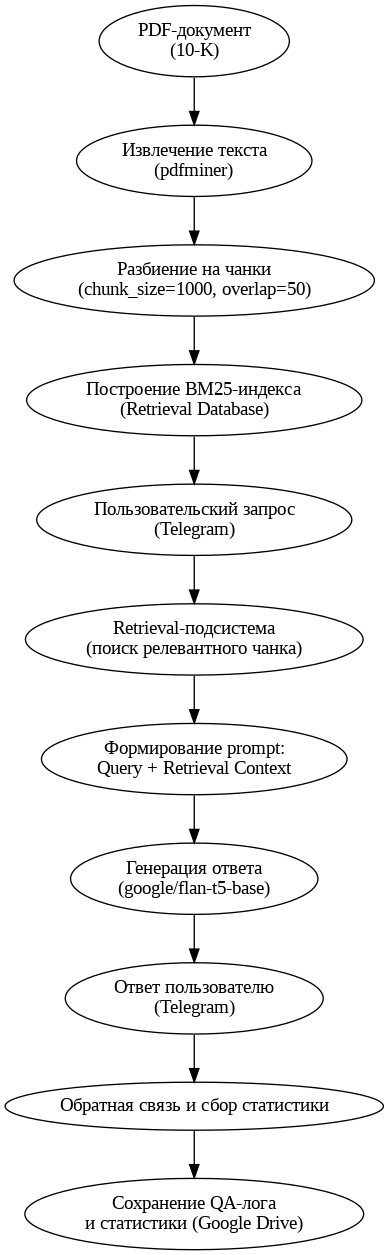

In [5]:
from IPython.display import Image, display
display(Image('rag_system_diagram.png'))


# LLM

**Метрики:**

BLEU (Bilingual Evaluation Understudy) score — это метрика, изначально разработанная для оценки качества машинного перевода, которая сравнивает n-граммы сгенерированного текста с n-граммами эталонного (reference) текста. Чем выше BLEU score, тем больше совпадений между сгенерированным и эталонным текстами, что свидетельствует о лучшем качестве генерации.

In [10]:
import difflib
from transformers import pipeline as hf_pipeline
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download('punkt')
nltk.download('punkt_tab')

class LLMPipeline:
    """
    Класс для работы с LLM в задачах Retrieval-Augmented Generation (RAG).

    Позволяет:
      - Генерировать ответ на основе retrieval контекста и запроса.
      - Генерировать ответ "zero-shot" (без контекста).
      - Оценивать качество сгенерированных ответов с использованием нескольких метрик:
            SequenceMatcher similarity, BLEU, ROUGE-L.
    """
    def __init__(self, model_name, max_length=200, do_sample=False, pipeline_type="text2text-generation"):
        """
        Инициализация объекта.

        :param model_name: Имя модели для генерации ответов (например, "google/flan-t5-base").
        :param max_length: Максимальная длина генерируемого ответа.
        :param do_sample: Использовать ли сэмплинг при генерации.
        """
        self.model_pipeline = hf_pipeline(pipeline_type, model=model_name, tokenizer=model_name)
        self.max_length = max_length
        self.do_sample = do_sample

    def generate_answer(self, query, context):
        """
        Формирует prompt с retrieval контекстом и генерирует ответ.

        :param query: Текст запроса.
        :param context: Текст retrieval контекста (например, найденный чанк).
        :return: Сгенерированный ответ (строка).
        """
        prompt = f"""Use the following context extracted from the document to answer the question.
If the answer is not contained in the context, say "I don't know."

Context:
{context}

Question:
{query}

Answer:"""
        result = self.model_pipeline(prompt, max_length=self.max_length, do_sample=self.do_sample)
        return result[0]['generated_text'].strip()

    def generate_answer_no_context(self, query):
        """
        Формирует prompt без retrieval контекста и генерирует ответ (zero-shot).

        :param query: Текст запроса.
        :return: Сгенерированный ответ (строка).
        """
        prompt = f"""Answer the following question:
{query}

Answer:"""
        result = self.model_pipeline(prompt, max_length=self.max_length, do_sample=self.do_sample)
        return result[0]['generated_text'].strip()

    def compute_bleu(self, reference, candidate):
        """
        Вычисляет BLEU score между reference и candidate.
        """
        ref_tokens = nltk.word_tokenize(reference)
        cand_tokens = nltk.word_tokenize(candidate)
        smoothing = SmoothingFunction().method1
        bleu = sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoothing)
        return bleu

    def compute_rouge(self, reference, candidate):
        """
        Вычисляет ROUGE-L F-measure между reference и candidate.
        """
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        scores = scorer.score(reference, candidate)
        return scores['rougeL'].fmeasure

    def evaluate(self, queries, true_answers, retrieval_function, expected_pages, top_k=1):
        """
        Выполняет оценку LLM с retrieval контекстом.

        Для каждого запроса:
          - Извлекается retrieval контекст с помощью retrieval_function.
          - Формируется prompt и генерируется ответ.
          - Вычисляются метрики: SequenceMatcher similarity, BLEU, ROUGE-L.
          - Выводится номер страницы retrieval контекста для проверки.

        :param queries: Список текстовых запросов.
        :param true_answers: Список истинных ответов.
        :param retrieval_function: Функция, которая по запросу возвращает retrieval результат (список словарей с ключами "page" и "chunk").
        :param expected_pages: Список ожидаемых номеров страниц для каждого запроса.
        :param top_k: Количество кандидатов retrieval (по умолчанию 1).
        :return: Словарь со средними значениями метрик.
        """
        total_similarity = 0
        total_bleu = 0
        total_rouge = 0
        total = len(queries)

        for idx, query in enumerate(queries):
            retrieval_result = retrieval_function(query, top_k=top_k)[0]
            retrieved_page = retrieval_result.get("page", "Unknown")
            context = retrieval_result.get("chunk", "")

            generated_answer = self.generate_answer(query, context)
            true_answer = true_answers[idx].strip()

            sim = difflib.SequenceMatcher(None, generated_answer, true_answer).ratio()
            bleu = self.compute_bleu(true_answer, generated_answer)
            rouge = self.compute_rouge(true_answer, generated_answer)

            total_similarity += sim
            total_bleu += bleu
            total_rouge += rouge

            print(f"\nEvaluation with Context - Вопрос {idx+1}: {query}")
            print("Ожидаемая страница:", expected_pages[idx])
            print("Retrieval контекст со страницы:", retrieved_page)
            print("Сгенерированный ответ:")
            print(generated_answer)
            print("Истинный ответ:")
            print(true_answer)
            print(f"SequenceMatcher Similarity: {sim * 100:.2f}%")
            print(f"BLEU score: {bleu * 100:.2f}%")
            print(f"ROUGE-L F1: {rouge * 100:.2f}%")

        avg_sim = total_similarity / total if total > 0 else 0
        avg_bleu = total_bleu / total if total > 0 else 0
        avg_rouge = total_rouge / total if total > 0 else 0

        print("\nСредние метрики с Context:")
        print(f"Средняя SequenceMatcher Similarity: {avg_sim * 100:.2f}%")
        print(f"Средний BLEU score: {avg_bleu * 100:.2f}%")
        print(f"Средний ROUGE-L F1: {avg_rouge * 100:.2f}%")

        return {
            "avg_similarity": avg_sim,
            "avg_bleu": avg_bleu,
            "avg_rouge": avg_rouge
        }

    def evaluate_no_context(self, queries, true_answers):
        """
        Выполняет оценку LLM в режиме zero-shot (без retrieval контекста).

        Для каждого запроса:
          - Генерируется ответ без предоставления retrieval контекста.
          - Вычисляются метрики: SequenceMatcher similarity, BLEU, ROUGE-L.

        :param queries: Список текстовых запросов.
        :param true_answers: Список истинных ответов.
        :return: Словарь со средними значениями метрик.
        """
        total_similarity = 0
        total_bleu = 0
        total_rouge = 0
        total = len(queries)

        for idx, query in enumerate(queries):
            generated_answer = self.generate_answer_no_context(query)
            true_answer = true_answers[idx].strip()

            sim = difflib.SequenceMatcher(None, generated_answer, true_answer).ratio()
            bleu = self.compute_bleu(true_answer, generated_answer)
            rouge = self.compute_rouge(true_answer, generated_answer)

            total_similarity += sim
            total_bleu += bleu
            total_rouge += rouge

            print(f"\nEvaluation without Context - Вопрос {idx+1}: {query}")
            print("Сгенерированный zero-shot ответ:")
            print(generated_answer)
            print("Истинный ответ:")
            print(true_answer)
            print(f"SequenceMatcher Similarity: {sim * 100:.2f}%")
            print(f"BLEU score: {bleu * 100:.2f}%")
            print(f"ROUGE-L F1: {rouge * 100:.2f}%")

        avg_sim = total_similarity / total if total > 0 else 0
        avg_bleu = total_bleu / total if total > 0 else 0
        avg_rouge = total_rouge / total if total > 0 else 0

        print("\nСредние метрики без Context:")
        print(f"Средняя SequenceMatcher Similarity: {avg_sim * 100:.2f}%")
        print(f"Средний BLEU score: {avg_bleu * 100:.2f}%")
        print(f"Средний ROUGE-L F1: {avg_rouge * 100:.2f}%")

        return {
            "avg_similarity": avg_sim,
            "avg_bleu": avg_bleu,
            "avg_rouge": avg_rouge
        }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
pipeline = PDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50)
pipeline.load_chunks("/content/drive/MyDrive/diploma/apple_chunks.pkl")

def retrieval_fn(query, top_k=1):
    return pipeline.search_query(query, top_k=top_k)

Чанки загружены из /content/drive/MyDrive/diploma/apple_chunks.pkl


## without R and google/flan-t5-base

In [ ]:
llm_pipeline_obj = LLMPipeline(model_name="google/flan-t5-base", max_length=200, do_sample=False)

print("=== Evaluation with Retrieval Context ===")
metrics_with_context = llm_pipeline_obj.evaluate(apple_prompt, apple_answers, retrieval_fn, apple_pages, top_k=1)

print("\n=== Zero-Shot Evaluation (without Retrieval Context) ===")
metrics_no_context = llm_pipeline_obj.evaluate_no_context(apple_prompt, apple_answers)

Device set to use cpu


=== Evaluation with Retrieval Context ===


Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors



Evaluation with Context - Вопрос 1: What was the percentage increase in Apple Inc.'s stock price from September 2019 to September 2024?
Ожидаемая страница: 23
Retrieval контекст со страницы: 23
Сгенерированный ответ:
I don't know.
Истинный ответ:
The stock price increased by 330% (from 100 to 430).
SequenceMatcher Similarity: 18.46%
BLEU score: 0.89%
ROUGE-L F1: 0.00%

Evaluation with Context - Вопрос 2: What are the two material performance obligations in Apple’s sales arrangements?
Ожидаемая страница: 38
Retrieval контекст со страницы: 112
Сгенерированный ответ:
short-swing profit transactions
Истинный ответ:
1) Hardware + bundled software, 2) Right to bundled services (iCloud, Siri, Maps)
SequenceMatcher Similarity: 17.86%
BLEU score: 0.00%
ROUGE-L F1: 0.00%

Evaluation with Context - Вопрос 3: When was the €1,000,000,000 aggregate principal amount of the 0.000% 2025 Notes issued?
Ожидаемая страница: 63
Retrieval контекст со страницы: 63
Сгенерированный ответ:
November 15, 2019
Ист

**Средние метрики с Context:**

Средняя SequenceMatcher Similarity: 34.37%

Средний BLEU score: 10.79%

Средний ROUGE-L F1: 22.49%

**Средние метрики без Context:**

Средняя SequenceMatcher Similarity: 22.93%

Средний BLEU score: 2.37%

Средний ROUGE-L F1: 5.55%

## t5-base - only True/False?

In [ ]:
llm_pipeline_obj2 = LLMPipeline(model_name="t5-base", max_length=200, do_sample=False)

print("=== Evaluation with Retrieval Context ===")
metrics_with_context = llm_pipeline_obj2.evaluate(apple_prompt, apple_answers, retrieval_fn, apple_pages, top_k=1)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


=== Evaluation with Retrieval Context ===

Evaluation with Context - Вопрос 1: What was the percentage increase in Apple Inc.'s stock price from September 2019 to September 2024?
Ожидаемая страница: 23
Retrieval контекст со страницы: 23
Сгенерированный ответ:
False
Истинный ответ:
The stock price increased by 330% (from 100 to 430).
SequenceMatcher Similarity: 10.53%
BLEU score: 0.00%
ROUGE-L F1: 0.00%

Evaluation with Context - Вопрос 2: What are the two material performance obligations in Apple’s sales arrangements?
Ожидаемая страница: 38
Retrieval контекст со страницы: 112
Сгенерированный ответ:
True
Истинный ответ:
1) Hardware + bundled software, 2) Right to bundled services (iCloud, Siri, Maps)
SequenceMatcher Similarity: 7.06%
BLEU score: 0.00%
ROUGE-L F1: 0.00%

Evaluation with Context - Вопрос 3: When was the €1,000,000,000 aggregate principal amount of the 0.000% 2025 Notes issued?
Ожидаемая страница: 63
Retrieval контекст со страницы: 63
Сгенерированный ответ:
True
Истинный о

**Средние метрики с Context:**

Средняя SequenceMatcher Similarity: 7.17%

Средний BLEU score: 0.00%

Средний ROUGE-L F1: 0.00%

## google/flan-t5-xl

In [ ]:
llm_pipeline_obj3 = LLMPipeline(model_name="google/flan-t5-xl", max_length=200, do_sample=False) #need gpu

metrics_with_context = llm_pipeline_obj3.evaluate(apple_prompt, apple_answers, retrieval_fn, apple_pages, top_k=1)

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors



Evaluation with Context - Вопрос 1: What was the percentage increase in Apple Inc.'s stock price from September 2019 to September 2024?
Ожидаемая страница: 23
Retrieval контекст со страницы: 23
Сгенерированный ответ:
I don't know
Истинный ответ:
The stock price increased by 330% (from 100 to 430).
SequenceMatcher Similarity: 15.62%
BLEU score: 0.00%
ROUGE-L F1: 0.00%

Evaluation with Context - Вопрос 2: What are the two material performance obligations in Apple’s sales arrangements?
Ожидаемая страница: 38
Retrieval контекст со страницы: 112
Сгенерированный ответ:
I don't know
Истинный ответ:
1) Hardware + bundled software, 2) Right to bundled services (iCloud, Siri, Maps)
SequenceMatcher Similarity: 15.05%
BLEU score: 0.00%
ROUGE-L F1: 0.00%

Evaluation with Context - Вопрос 3: When was the €1,000,000,000 aggregate principal amount of the 0.000% 2025 Notes issued?
Ожидаемая страница: 63
Retrieval контекст со страницы: 63
Сгенерированный ответ:
November 15, 2019
Истинный ответ:
Novembe

**Средние метрики с Context:**

Средняя SequenceMatcher Similarity: 36.36%

Средний BLEU score: 17.02%

Средний ROUGE-L F1: 28.49%

## bigscience/bloom-560m

In [ ]:
llm_pipeline_obj4 = LLMPipeline(model_name="bigscience/bloom-560m", max_length=1000, do_sample=False, pipeline_type='text-generation')
metrics_with_context = llm_pipeline_obj4.evaluate(apple_prompt, apple_answers, retrieval_fn, apple_pages, top_k=1)

# Telegram @TechCompAABot

## tg bot pipeline

In [12]:
import logging
import json
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackQueryHandler
from telegram import InlineKeyboardMarkup, InlineKeyboardButton

class TelegramRAGBot:
    """
    Класс для Telegram-бота, использующего Retrieval-Augmented Generation (RAG).

    При получении запроса бот:
      - Вызывает retrieval-пайплайн для получения релевантного контекста.
      - Передаёт запрос и извлечённый контекст в LLM для генерации ответа.
      - Отправляет сгенерированный ответ пользователю.
      - Собирает статистику запросов и сохраняет пары "вопрос–ответ" для дальнейшего обучения.
    """
    def __init__(self, token, retrieval_pipeline, llm_pipeline, stats_path, qa_log_path):
        """
        Инициализация бота.

        :param token: Telegram API-токен.
        :param retrieval_pipeline: Объект retrieval-пайплайна (например, экземпляр PDFRAGPipeline).
        :param llm_pipeline: Объект LLM-пайплайна (например, экземпляр LLMPipeline).
        :param stats_path: Путь для сохранения статистики (например, на Google Drive).
        :param qa_log_path: Путь для сохранения QA-лога.
        """
        self.token = token
        self.retrieval_pipeline = retrieval_pipeline
        self.llm_pipeline = llm_pipeline
        self.stats_path = stats_path
        self.qa_log_path = qa_log_path

        # Статистика: число запросов, правильных и неправильных ответов.
        self.stats = {"total": 0, "correct": 0, "incorrect": 0}
        # QA-лог: список записей, каждая запись содержит запрос, retrieval контекст, страницу, сгенерированный ответ и feedback.
        self.qa_log = []

        logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                            level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        self.updater = Updater(token, use_context=True)
        self.dp = self.updater.dispatcher

        self.setup_handlers()

    def setup_handlers(self):
        """Настраивает обработчики команд и сообщений."""
        self.dp.add_handler(CommandHandler("start", self.start))
        self.dp.add_handler(CommandHandler("stats", self.stats_command))
        self.dp.add_handler(CommandHandler("savestats", self.save_stats_command))
        self.dp.add_handler(CommandHandler("saveqa", self.save_qa_log_command))
        self.dp.add_handler(MessageHandler(Filters.text & ~Filters.command, self.answer_query))
        self.dp.add_handler(CallbackQueryHandler(self.feedback_callback, pattern='^feedback_'))

    def start(self, update, context):
        """Обработчик команды /start."""
        update.message.reply_text("Привет! Отправь мне вопрос, и я постараюсь ответить с использованием модели RAG.")

    def stats_command(self, update, context):
        """Обрабатывает команду /stats и выводит текущую статистику."""
        stats_text = json.dumps(self.stats, indent=4, ensure_ascii=False)
        update.message.reply_text(f"Текущая статистика:\n{stats_text}")

    def save_stats_command(self, update, context):
        """Команда /savestats сохраняет статистику в файл."""
        self.save_stats(self.stats_path)
        update.message.reply_text(f"Статистика сохранена в {self.stats_path}")

    def save_qa_log_command(self, update, context):
        """Команда /saveqa сохраняет QA-лог в файл."""
        self.save_qa_log(self.qa_log_path)
        update.message.reply_text(f"QA-лог сохранен в {self.qa_log_path}")

    def answer_query(self, update, context):
        """Обрабатывает текстовые сообщения и возвращает сгенерированный ответ."""
        user_query = update.message.text
        try:
            # Получаем retrieval результат (лучший найденный чанк)
            retrieval_result = self.retrieval_pipeline.search_query(user_query, top_k=1)[0]
            context_text = retrieval_result.get("chunk", "")
            retrieved_page = retrieval_result.get("page", "Unknown")

            # Генерируем ответ с использованием LLM
            answer = self.llm_pipeline.generate_answer(user_query, context_text)
            reply_text = f"Ответ (retrieved from page {retrieved_page}):\n{answer}\n\nОцените, верный ли ответ:"

            # Обновляем статистику
            self.stats["total"] += 1

            # Добавляем запись в QA-лог (feedback пока None)
            qa_record = {
                "query": user_query,
                "retrieval_context": context_text,
                "retrieved_page": retrieved_page,
                "generated_answer": answer,
                "feedback": None
            }
            self.qa_log.append(qa_record)

            # Создаем inline-клавиатуру для обратной связи
            keyboard = [
                [
                    InlineKeyboardButton("Верный", callback_data="feedback_yes"),
                    InlineKeyboardButton("Неверный", callback_data="feedback_no")
                ]
            ]
            reply_markup = InlineKeyboardMarkup(keyboard)
            update.message.reply_text(reply_text, reply_markup=reply_markup)
        except Exception as e:
            self.logger.error(f"Error processing query: {e}")
            update.message.reply_text("Произошла ошибка при обработке запроса. Попробуйте позже.")

    def feedback_callback(self, update, context):
        """Обрабатывает нажатия на кнопки обратной связи."""
        query = update.callback_query
        query.answer()  # обязательно вызываем
        feedback = query.data  # "feedback_yes" или "feedback_no"
        if feedback == "feedback_yes":
            self.stats["correct"] += 1
            feedback_value = "yes"
            response = "Спасибо за обратную связь! Рад, что ответ верный."
        else:
            self.stats["incorrect"] += 1
            feedback_value = "no"
            response = "Спасибо за обратную связь! Мы учтём это для улучшения."
        # Обновляем последний QA-запись, если feedback ещё не установлен
        if self.qa_log and self.qa_log[-1]["feedback"] is None:
            self.qa_log[-1]["feedback"] = feedback_value
        # Сохраняем статистику и QA-лог
        self.save_stats(self.stats_path)
        self.save_qa_log(self.qa_log_path)
        query.edit_message_reply_markup(reply_markup=None)
        query.message.reply_text(response)

    def save_stats(self, stats_path):
        """
        Сохраняет статистику (self.stats) в файл в формате JSON.

        :param stats_path: Путь для сохранения файла статистики.
        """
        try:
            with open(stats_path, "w", encoding="utf-8") as f:
                json.dump(self.stats, f, ensure_ascii=False, indent=4)
            self.logger.info(f"Статистика сохранена в {stats_path}")
        except Exception as e:
            self.logger.error(f"Ошибка при сохранении статистики: {e}")

    def load_stats(self, stats_path):
        """
        Загружает статистику из файла (JSON) и записывает в self.stats.

        :param stats_path: Путь к файлу статистики.
        :return: Загруженная статистика.
        """
        try:
            with open(stats_path, "r", encoding="utf-8") as f:
                self.stats = json.load(f)
            self.logger.info(f"Статистика загружена из {stats_path}")
        except Exception as e:
            self.logger.error(f"Ошибка при загрузке статистики: {e}")
        return self.stats

    def save_qa_log(self, qa_log_path):
        """
        Сохраняет QA-лог (self.qa_log) в файл в формате JSON.

        :param qa_log_path: Путь для сохранения QA-лога.
        """
        try:
            with open(qa_log_path, "w", encoding="utf-8") as f:
                json.dump(self.qa_log, f, ensure_ascii=False, indent=4)
            self.logger.info(f"QA-лог сохранен в {qa_log_path}")
        except Exception as e:
            self.logger.error(f"Ошибка при сохранении QA-лога: {e}")

    def load_qa_log(self, qa_log_path):
        """
        Загружает QA-лог из файла (JSON) и сохраняет в self.qa_log.

        :param qa_log_path: Путь к файлу QA-лога.
        :return: Загруженный QA-лог.
        """
        try:
            with open(qa_log_path, "r", encoding="utf-8") as f:
                self.qa_log = json.load(f)
            self.logger.info(f"QA-лог загружен из {qa_log_path}")
        except Exception as e:
            self.logger.error(f"Ошибка при загрузке QA-лога: {e}")
        return self.qa_log

    def run(self):
        """Запускает бота (polling)."""
        self.updater.start_polling()
        self.updater.idle()


In [ ]:
token = "7977851701:AAEbQ7K6_OOTos_F_zyLlZYUSJ8TzyJKB6w"

pdf_path = "/content/drive/MyDrive/diploma/2 apple_10k.pdf"
retrieval_pipeline = PDFRAGPipeline(pdf_path, chunk_size=1000, overlap=50)
retrieval_pipeline.load_chunks("/content/drive/MyDrive/diploma/apple_chunks.pkl")
retrieval_pipeline.build_index()

llm_pipeline_obj = LLMPipeline_for_bot(model_name="google/flan-t5-base", max_length=200, do_sample=False)

Чанки загружены из /content/drive/MyDrive/diploma/apple_chunks.pkl


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


In [ ]:
# Создаем и запускаем Telegram бота
bot = TelegramRAGBot(token, retrieval_pipeline, llm_pipeline_obj, stats_path="/content/drive/MyDrive/diploma/bot_stats.json",
                     qa_log_path="/content/drive/MyDrive/diploma/full_qa_bot_stats.json")
bot.run()

In [ ]:
stats_path = "/content/drive/MyDrive/diploma/full_qa_bot_stats.json"

try:
    with open(stats_path, "r", encoding="utf-8") as f:
        stats = json.load(f)
    print("Статистика бота:")
    print(json.dumps(stats, indent=4, ensure_ascii=False))
except Exception as e:
    print(f"Ошибка при чтении статистики: {e}")

Статистика бота:
[
    {
        "query": "Why Greater China net sales increased during 2024 compared to 2023?",
        "retrieval_context": "Segment Operating Performance The following table shows net sales by reportable segment for 2024, 2023 and 2022 (dollars in millions): Americas Europe Greater China Japan Rest of Asia Pacific Total net sales Americas 2024 Change 2023 Change 2022 $ 167,045 3 % $ 162,560 (4) % $ 169,658 101,328 66,952 25,052 30,658 7 % (8) % 3 % 4 % 94,294 72,559 24,257 29,615 (1) % (2) % (7) % 1 % 95,118 74,200 25,977 29,375 $ 391,035 2 % $ 383,285 (3) % $ 394,328 Americas net sales increased during 2024 compared to 2023 due primarily to higher net sales of Services. Europe Europe net sales increased during 2024 compared to 2023 due primarily to higher net sales of Services and iPhone. Greater China Greater China net sales decreased during 2024 compared to 2023 due primarily to lower net sales of iPhone and iPad. The weakness in the renminbi relative to the U.S. 

In [13]:
!pip freeze > requirements.txt